# Applications of ML for Networking Final Project
---
#### Name: 劉耀文 (Yao-Wen Liu)
#### Student ID: 311551045
---

## Data Input and library import

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

import warnings
warnings.filterwarnings("ignore")

column_name = ['NSS', 'MCS', 'GI', 'throughput', 'airtime_per', 'other_per']
dataset = pd.read_csv('network_trace.txt', sep=" ", names=column_name, header=None)
dataset

,NSS,MCS,GI,throughput,airtime_per,other_per
0,2,6,1,51.055077,0.075920,0.0
1,2,7,1,50.742508,0.093920,0.0
2,1,9,1,51.897148,0.093228,0.0
3,2,8,1,49.850716,0.095052,0.0
4,2,5,1,51.727776,0.100688,0.0
...,...,...,...,...,...,...
367,1,9,0,51.375793,0.136256,0.0
368,2,5,0,49.931450,0.107029,0.0
369,2,4,0,50.180573,0.124320,0.0
370,2,5,0,49.762260,0.108120,0.0


## Data Preprocessing
* Most of the preprocessing is done in the publisher.py / subscriber.py.
* The label is from the next second's throughput
    * If throughput >= 60 Mbps, then quality = 0 (1080p)
    * 60 > tp >= 40, quality = 1 (900p)
    * 40 > tp >= 30, quality = 2 (720p)
    * 30 > tp >= 20, quality = 3 (540p)
    * 20 > tp      , quality = 4 (360p)

In [144]:
label = []
for i in range(1, len(dataset)):
    if(dataset.at[i, 'throughput'] >= 50):
        label.append(0)
    elif(dataset.at[i, 'throughput'] >= 40):
        label.append(1)
    elif(dataset.at[i, 'throughput'] >= 30):
        label.append(2)
    elif(dataset.at[i, 'throughput'] >= 20):
        label.append(3)
    else:
        label.append(4)
label.append(0)
dataset['label'] = label
dataset
print(label)

[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 1, 2, 1, 2, 4, 3, 3, 4, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 2, 3, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 4, 4, 2, 4, 4, 4, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 4, 3, 4, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 3, 2, 2, 0, 1, 0, 1, 0, 1, 1, 1, 2, 3, 4, 3, 4, 4, 4, 4, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 3, 4, 3, 3, 3, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 1, 4, 4, 2, 1, 1, 3, 4, 3, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 3, 2, 

In [145]:
# drop first row because the label is not correct
dataset = dataset.drop(dataset.index[-1], axis=0)

# drop the throughput column, which is replaced by the quality
dataset = dataset.drop(['throughput'], axis=1)

# Shuffle the data.
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset

,NSS,MCS,GI,airtime_per,other_per,label
0,2,2,1,0.237363,0.188272,3
1,2,7,0,0.094800,0.000000,1
2,2,4,0,0.077216,0.000000,2
3,2,5,1,0.162264,0.000000,0
4,2,1,1,0.183832,0.494747,3
...,...,...,...,...,...,...
366,2,7,1,0.092340,0.000000,0
367,2,4,1,0.094380,0.000000,0
368,2,2,1,0.143104,0.501871,4
369,1,2,1,0.149268,0.526155,4


## Data Visualization

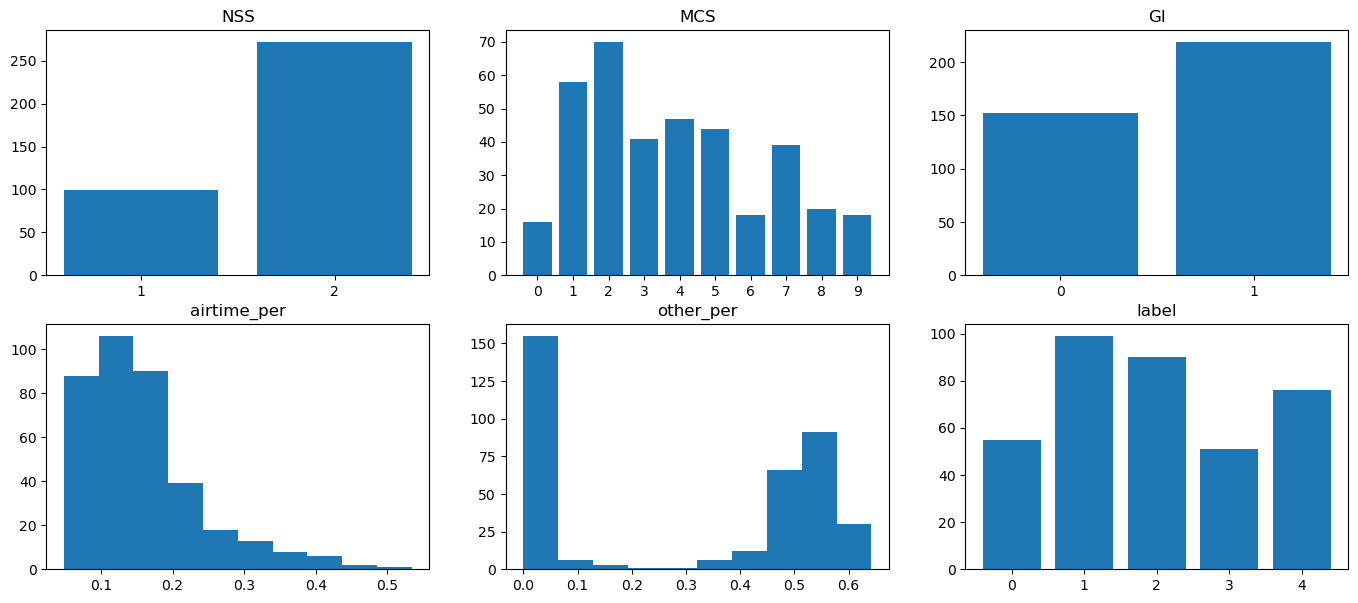

In [146]:
index = 0
plt.figure(figsize=(16.8, 7))
for feature in dataset:
    plt.subplot(2, 3, index + 1)
    # numeric features
    if feature == 'airtime_per' or feature == 'other_per':
        plt.hist(dataset[feature], bins=10, range=[dataset[feature].min(), dataset[feature].max()])
        plt.title(feature)
    # symbolic features
    else:
        tmp_col = dataset[feature].astype(str)
        labels, i=np.unique(tmp_col, return_index=True)
        counts=[]
        for j in range(0,len(labels)):
            counts.append(tmp_col.tolist().count(labels[j]))
        plt.bar(labels, counts)
        plt.title(feature)
    index += 1
plt.savefig('data_visualization.png', bbox_inches='tight')

## Model Construction and Performance
#### K-Fold

In [147]:
y_train = dataset['label']
X_train = dataset.drop(['label'], axis=1)

k_fold = KFold(n_splits=3)
k_fold.get_n_splits(X_train)

3

#### Decision Tree

iteration #1 Recall: [0.6        0.59259259 0.34285714 0.22222222 0.45833333]
iteration #1 Precision: [0.57142857 0.42105263 0.46153846 0.25       0.47826087]
iteration #1 F1-Score: [0.58536585 0.49230769 0.39344262 0.23529412 0.46808511]
Average: 0.4432, 0.43646, 0.4349

iteration #2 Recall: [0.1875     0.26470588 0.44827586 0.2        0.56666667]
iteration #2 Precision: [0.17647059 0.375      0.39393939 0.14285714 0.5862069 ]
iteration #2 F1-Score: [0.18181818 0.31034483 0.41935484 0.16666667 0.57627119]
Average: 0.33343, 0.33489, 0.33089

iteration #3 Recall: [0.57894737 0.39473684 0.38461538 0.22222222 0.45454545]
iteration #3 Precision: [0.33333333 0.55555556 0.37037037 0.26666667 0.47619048]
iteration #3 F1-Score: [0.42307692 0.46153846 0.37735849 0.24242424 0.46511628]
Average: 0.40701, 0.40042, 0.3939



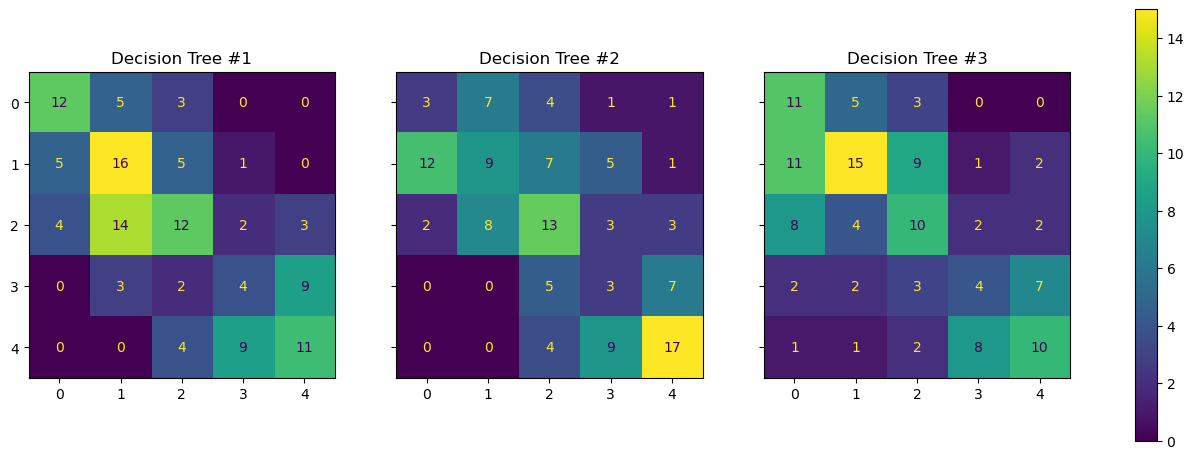

In [148]:
iteration = 1
conf_matrix = []
clf = DecisionTreeClassifier(criterion="entropy")
for train_index, validation_index in k_fold.split(X_train):
    x_train_cv, x_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train[train_index], y_train[validation_index]
    
    clf.fit(x_train_cv, y_train_cv)
    y_predict_cv = clf.predict(x_validation_cv)
    
    conf_matrix.append(confusion_matrix(y_true=y_validation_cv, y_pred=y_predict_cv))
    recall = recall_score(y_validation_cv, y_predict_cv, average=None)
    precision = precision_score(y_validation_cv, y_predict_cv, average=None)
    f1 = f1_score(y_validation_cv, y_predict_cv, average=None)

    print(f'iteration #{iteration} Recall: {recall}')
    print(f'iteration #{iteration} Precision: {precision}')
    print(f'iteration #{iteration} F1-Score: {f1}')
    print(f'Average: {np.round(np.average(recall), 5)}, {np.round(np.average(precision), 5)}, {np.round(np.average(f1), 5)}')
    print()
    iteration += 1


titles = ['Decision Tree #1', 'Decision Tree #2', 'Decision Tree #3']

f, axes = plt.subplots(1, 3, figsize=(16.8, 5.6), sharey='row')

for i in range(0,3):
    disp = ConfusionMatrixDisplay(conf_matrix[i], display_labels=labels)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.savefig(f'confusion_matrix_decision_tree.png', bbox_inches='tight')
plt.show()

#### Random Forest

In [149]:
parameters = {'n_estimators':[3, 5, 10, 20, 40, 50], 'criterion':['gini', 'entropy'], 'bootstrap': [True, False]}
rf_clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, refit=True, cv=3)
rf_clf.fit(X_train, y_train)
best_rf_clf = rf_clf.best_estimator_
print(f'Parameter used for best estimator: {rf_clf.best_params_}')
print(f'Score of best estimator: {np.round(rf_clf.best_score_, 5)}')

Parameter used for best estimator: {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 50}
Score of best estimator: 0.46355


iteration #1 Recall: [0.6        0.44444444 0.4        0.27777778 0.79166667]
iteration #1 Precision: [0.52173913 0.4137931  0.48275862 0.45454545 0.59375   ]
iteration #1 F1-Score: [0.55813953 0.42857143 0.4375     0.34482759 0.67857143]
Average: 0.50278, 0.49332, 0.48952

iteration #2 Recall: [0.1875     0.41176471 0.55172414 0.26666667 0.76666667]
iteration #2 Precision: [0.2        0.4516129  0.5        0.28571429 0.71875   ]
iteration #2 F1-Score: [0.19354839 0.43076923 0.52459016 0.27586207 0.74193548]
Average: 0.43686, 0.43122, 0.43334

iteration #3 Recall: [0.57894737 0.44736842 0.5        0.16666667 0.5       ]
iteration #3 Precision: [0.44       0.5862069  0.36111111 0.3        0.47826087]
iteration #3 F1-Score: [0.5        0.50746269 0.41935484 0.21428571 0.48888889]
Average: 0.4386, 0.43312, 0.426



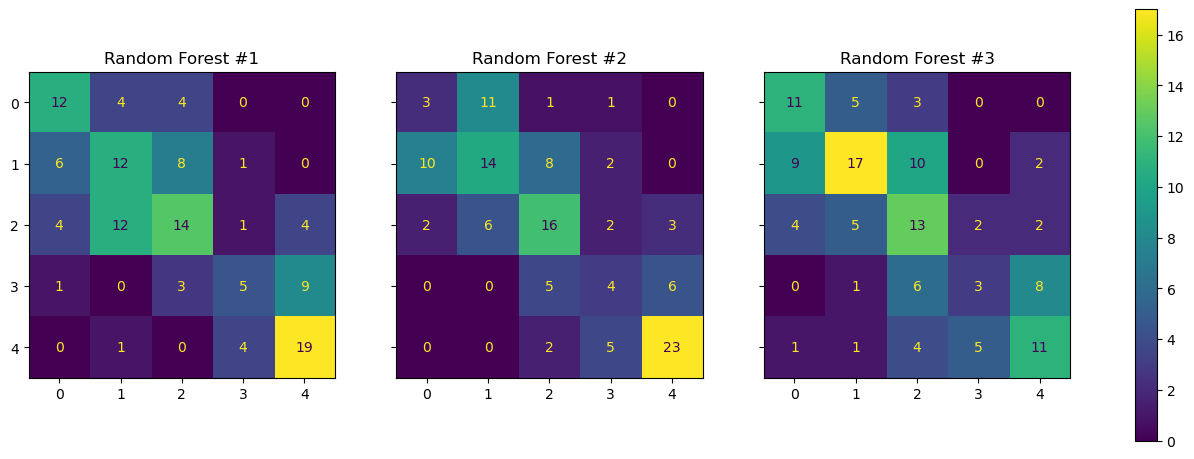

In [150]:
iteration = 1
conf_matrix = []
clf = RandomForestClassifier(criterion="gini", n_estimators=40, bootstrap=True)
for train_index, validation_index in k_fold.split(X_train):
    x_train_cv, x_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train[train_index], y_train[validation_index]
    
    clf.fit(x_train_cv, y_train_cv)
    y_predict_cv = clf.predict(x_validation_cv)
    
    conf_matrix.append(confusion_matrix(y_true=y_validation_cv, y_pred=y_predict_cv))
    recall = recall_score(y_validation_cv, y_predict_cv, average=None)
    precision = precision_score(y_validation_cv, y_predict_cv, average=None)
    f1 = f1_score(y_validation_cv, y_predict_cv, average=None)

    print(f'iteration #{iteration} Recall: {recall}')
    print(f'iteration #{iteration} Precision: {precision}')
    print(f'iteration #{iteration} F1-Score: {f1}')
    print(f'Average: {np.round(np.average(recall), 5)}, {np.round(np.average(precision), 5)}, {np.round(np.average(f1), 5)}')
    print()
    iteration += 1


titles = ['Random Forest #1', 'Random Forest #2', 'Random Forest #3']

f, axes = plt.subplots(1, 3, figsize=(16.8, 5.6), sharey='row')

for i in range(0,3):
    disp = ConfusionMatrixDisplay(conf_matrix[i], display_labels=labels)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.savefig(f'confusion_matrix_random_forest.png', bbox_inches='tight')
plt.show()

#### Linear Regression

iteration #1 Recall: [0.05       0.81481481 0.42857143 0.         0.95833333]
iteration #1 Precision: [1.         0.40740741 0.65217391 0.         0.52272727]
iteration #1 F1-Score: [0.0952381  0.54320988 0.51724138 0.         0.67647059]
Average: 0.45034, 0.51646, 0.36643

iteration #2 Recall: [0.125      0.55882353 0.48275862 0.13333333 0.83333333]
iteration #2 Precision: [0.15384615 0.5        0.60869565 0.2        0.625     ]
iteration #2 F1-Score: [0.13793103 0.52777778 0.53846154 0.16       0.71428571]
Average: 0.42665, 0.41751, 0.41569

iteration #3 Recall: [0.42105263 0.57894737 0.5        0.05555556 0.63636364]
iteration #3 Precision: [0.61538462 0.51162791 0.39393939 0.16666667 0.5       ]
iteration #3 F1-Score: [0.5        0.54320988 0.44067797 0.08333333 0.56      ]
Average: 0.43838, 0.43752, 0.42544



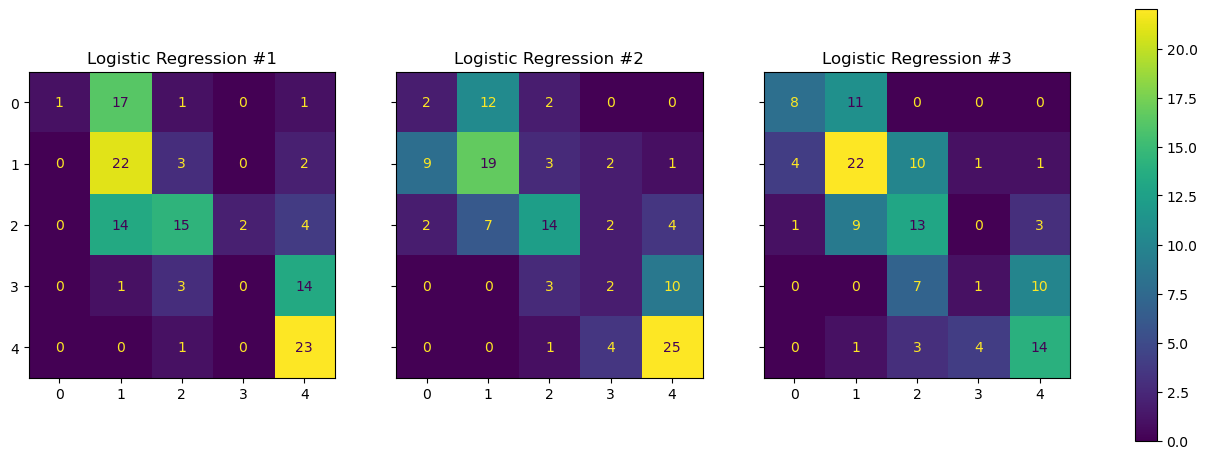

In [151]:
iteration = 1
conf_matrix = []
clf = LogisticRegression()
for train_index, validation_index in k_fold.split(X_train):
    x_train_cv, x_validation_cv = X_train.values[train_index], X_train.values[validation_index]
    y_train_cv, y_validation_cv = y_train[train_index], y_train[validation_index]
    
    clf.fit(x_train_cv, y_train_cv)
    y_predict_cv = clf.predict(x_validation_cv)
    
    conf_matrix.append(confusion_matrix(y_true=y_validation_cv, y_pred=y_predict_cv))
    recall = recall_score(y_validation_cv, y_predict_cv, average=None)
    precision = precision_score(y_validation_cv, y_predict_cv, average=None)
    f1 = f1_score(y_validation_cv, y_predict_cv, average=None)

    print(f'iteration #{iteration} Recall: {recall}')
    print(f'iteration #{iteration} Precision: {precision}')
    print(f'iteration #{iteration} F1-Score: {f1}')
    print(f'Average: {np.round(np.average(recall), 5)}, {np.round(np.average(precision), 5)}, {np.round(np.average(f1), 5)}')
    print()
    iteration += 1


titles = ['Logistic Regression #1', 'Logistic Regression #2', 'Logistic Regression #3']

f, axes = plt.subplots(1, 3, figsize=(16.8, 5.6), sharey='row')

for i in range(0,3):
    disp = ConfusionMatrixDisplay(conf_matrix[i], display_labels=labels)
    disp.plot(ax=axes[i])
    disp.ax_.set_title(titles[i])
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')

f.colorbar(disp.im_, ax=axes)
plt.savefig(f'confusion_matrix_Logistic_Regression.png', bbox_inches='tight')
plt.show()

## Modeling Saving
* Save the ML model as file to be imported by the adaptation module.

In [152]:
joblib.dump(clf, 'pre-trained_model')

['pre-trained_model']